# Телеком

## План работы

1. Сформировать цель и описание данных.
2. Произвести подготовку данных для анализа: 
    - Выгрузить данные 
    - Проверить наличие дубликатов, пропусков и соответствия типов данных
    - Объединить файлы для удобства изучения
3. Провести исследовательский анализ данных:
    - Сравнение распределения величин ежемесячных платежей всех клиентов и тех, кто ушел
    - Расчет стастических метрик для всех клиентов и тех, кто ушел: медиана, среднее, мин, мах, квантили
    - Графики, отображающие долю интернет-пользователей и пользователей телефонной связи
4. Подготовить данные для обучения: 
    - Разделение данных на обучающую и тестовую выборки
    - Кодирование категориальных признаков
    - Маcштабирование количественных признаков
    - Анализ баланса классов
5. Обучение простых моделей:
    - Обучение простых моделей с автоподобором дисбаланса классов
    - Обучение простых моделей с учетом дисбаланса классов (upsamaple, downsamle)
6. Тестирование лучшей модели
7. Обучение и тестирование модели градиентного бустинга.
8. Общие выводы

## 1. Цель и описание данных

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.


***Описание данных внутри представленных таблиц:*** 

**contract**:<div>
*customerID* - уникальный идентификатор клиента;<div>
*BeginDate* - дата подключения к оператору;<div>
*EndDate* - дата прекращения договора;<div>
*Type* - тип договора (с помесячной оплатой, годовой или двухгодовой);<div>
*Paperlessbilling* - электронный счет;<div>
*PaymentMethod* - метод оплаты;<div>
*MonthlyCharges* - ежемесячная плата за услуги;<div>
*TotalCharges* - общая плата за услуги за все время.

**personal**:<div>
*customerID* - уникальный идентификатор клиента;<div>
*Gender* - пол клиента;<div>
*SeniorCitizen* - является ли клиент пенсионером;<div>
*Partner* - наличие супруга/супруги;<div>
*Dependents* - наличие иждивенцев.

**internet**:<div>
*customerID* - уникальный идентификатор клиента;<div>
*InternetService* - тип подключения интернета (DSL, оптоволокно);<div>
*OnlineSecurity* - наличие услуги блокировки небезопасных сайтов;<div>
*OnlineBackup* - наличие облачного хранилища для создания резервных копий;<div>
*DeviceProtection* - наличие услуги антивируса;<div>
*TechSupport* - наличие выделенной линии технической поддержки;<div>
*StreamingTV* - наличие услуги онлайн-телевидения;<div>
*StreamingMovies* - наличие услуги онлайн-кинотеатра.

**phone**:<div>
*customerID* - уникальный идентификатор клиента;<div>
*MultipleLines* - наличие нескольких телефонных линий у клиента.<div>


## 2. Подготовка данных для анализа

In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st

import warnings
warnings.filterwarnings('ignore')


from IPython.display import display
pd.set_option('display.max_columns', 100)

import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, accuracy_score, roc_curve, make_scorer,roc_auc_score, recall_score
from sklearn.utils import shuffle

!pip install catboost

from catboost import CatBoostClassifier

!pip install category_encoders

from category_encoders import OneHotEncoder
import collections

In [4]:
#local
contract = pd.read_csv('/Users/katerinakasanova/Desktop/Обучение/final_provider/contract.csv', na_values=' ')
internet = pd.read_csv('/Users/katerinakasanova/Desktop/Обучение/final_provider/internet.csv', na_values=' ')
personal = pd.read_csv('/Users/katerinakasanova/Desktop/Обучение/final_provider/personal.csv', na_values=' ')
phone = pd.read_csv('/Users/katerinakasanova/Desktop/Обучение/final_provider/phone.csv', na_values=' ')

#yandex
contract = pd.read_csv('/datasets/final_provider/contract.csv', na_values=' ')
internet = pd.read_csv('/datasets/final_provider/internet.csv', na_values=' ')
personal = pd.read_csv('/datasets/final_provider/personal.csv', na_values=' ')
phone = pd.read_csv('/datasets/final_provider/phone.csv', na_values=' ')

**Данные о договорах**

In [3]:
display(contract.head())
contract.info()
contract.describe()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 440.3+ KB


,MonthlyCharges,TotalCharges
count,7043.000000,7032.000000
mean,64.761692,2283.300441
std,30.090047,2266.771362
min,18.250000,18.800000
25%,35.500000,401.450000
50%,70.350000,1397.475000
75%,89.850000,3794.737500
max,118.750000,8684.800000


In [4]:
print('Количество дубликатов:', contract.duplicated().sum())
print('Количество уникальных пользователей:', len(contract['customerID'].unique()))

Количество дубликатов: 0
Количество уникальных пользователей: 7043


В данных нет дубликатов, все представленные пользователи - уникальны.<div> Присутствует 11 пропусков в столбце TotalCharges. <div>Колонки с датой BeginDate (дата начала пользования услугами) и EndDate (дата окончания пользования услугами) имеют тип категориальных данных. Необходимо будет поменять.

In [5]:
#Изучим пропуски 
contract[contract.isnull().any(1)]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,NaN


Все пропуски по пользователям, которые стали клиентами 1 февраля 2020 года. Это дата когда делался срез данных. Так как они только присоединились, их поведение не понятно (останутся или уйдут) и таких пользователей всего 11 (достаточно маленький процент от общего числа), то удалим эти строки чтобы не портить обучение моделей.

In [6]:
contract=contract.dropna()
contract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   BeginDate         7032 non-null   object 
 2   EndDate           7032 non-null   object 
 3   Type              7032 non-null   object 
 4   PaperlessBilling  7032 non-null   object 
 5   PaymentMethod     7032 non-null   object 
 6   MonthlyCharges    7032 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 494.4+ KB


In [7]:
#поменяем тип данных у колонки BeginDate
contract['BeginDate']= pd.to_datetime(contract['BeginDate'], format ='%Y-%m-%d')

Создадим колонку СlientGroup, которая показывает является ли пользователь клиентом или уже ушел, основываясь на данных в колонке EndDate. Если даты в колонке нет, то пользователь является клиентом, если дата есть, то ушел.

In [8]:
def client_group(EndDate):
    try:
        if EndDate == 'No':
            return 0
        else:
            return 1
    except:
        print('ошибочное значение')
        
contract['СlientGroup'] = contract['EndDate'].apply(client_group) 
display(contract.head())
contract['СlientGroup'].unique()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,СlientGroup
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1


array([0, 1])

Посчитаем в отдельной колонке время жизни клиента Lifetime. Создадим копию колонки EndDate и заменим значение No на дату 2020-02-01 - дата когда делался срез данных. И вычислим разницу между EndDateCopy и BeginDate в днях.

In [9]:
contract['EndDateCopy']=contract['EndDate']
contract['EndDateCopy']=contract['EndDateCopy'].replace('No', '2020-02-01')
contract['EndDateCopy']=pd.to_datetime(contract['EndDateCopy'], format ='%Y-%m-%d')
contract['Lifetime']=(contract['EndDateCopy']-contract['BeginDate']).dt.days
contract=contract.drop(['EndDateCopy'], axis=1)
display(contract.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,СlientGroup,Lifetime
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,31
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,0,1036
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1,61
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1,61


In [10]:
contract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   object        
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float64       
 7   TotalCharges      7032 non-null   float64       
 8   СlientGroup       7032 non-null   int64         
 9   Lifetime          7032 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(5)
memory usage: 604.3+ KB


**Данные об интернет услугах**

In [11]:
display(internet.head())
internet.info()
internet.describe()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,7590-VHVEG,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [12]:
print('Количество дубликатов:', internet.duplicated().sum())
print('Количество уникальных пользователей:', len(internet['customerID'].unique()))

Количество дубликатов: 0
Количество уникальных пользователей: 5517


В данных нет дубликатов, все представленные пользователи - уникальны.<div> Но данных всего 5517 -  меньше чем кол-во пользователей в данных о договоре - это означает, что почти 20% пользователей не пользуются интернет услугами.

**Данные о персональных данных**

In [13]:
display(personal.head())
personal.info()
personal.describe()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [14]:
print('Количество дубликатов:', personal.duplicated().sum())
print('Количество уникальных пользователей:', len(personal['customerID'].unique()))

Количество дубликатов: 0
Количество уникальных пользователей: 7043


В данных нет дубликатов, все представленные пользователи - уникальны.<div> Данных на 11 больше, чем в информации о договорах, но вспомним, что мы удалили пустые значения. Будем учитывать это при объединении 

**Данные об услугах телефонии**

In [15]:
display(phone.head())
phone.info()
phone.describe()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,5575-GNVDE,No
freq,1,3390


In [16]:
print('Количество дубликатов:', phone.duplicated().sum())
print('Количество уникальных пользователей:', len(phone['customerID'].unique()))

Количество дубликатов: 0
Количество уникальных пользователей: 6361


В данных нет дубликатов, все представленные пользователи - уникальны.<div> Но данных всего 6361 -  меньше чем кол-во пользователей в данных о договоре - это означает, что почти 10% пользователей не пользуются услугами телефонии.

Пропуски в столбце TotalCharges удалены, тк их всего 11 шт, добавлен столбец СlientGroup с целевым признаком и столбец с дополнительным признаком Lifitime - время жизни клиента.

**Объединение данных**

Сначала объединим персональные данные и данные о контрактах. Изначально в обоих файлах было 7043 записей, но мы удалили 11 записей из данных о контрактах. Поэтому после объединения, удалим пропуски в общем файле.

In [17]:
full = pd.merge(personal, contract, on ='customerID',how= 'left')
full=full.dropna()
display(full.head())
full.info()

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,СlientGroup,Lifetime
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0.0,31.0
1,5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,0.0,1036.0
2,3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1.0,61.0
3,7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0.0,1371.0
4,9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1.0,61.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   gender            7032 non-null   object        
 2   SeniorCitizen     7032 non-null   int64         
 3   Partner           7032 non-null   object        
 4   Dependents        7032 non-null   object        
 5   BeginDate         7032 non-null   datetime64[ns]
 6   EndDate           7032 non-null   object        
 7   Type              7032 non-null   object        
 8   PaperlessBilling  7032 non-null   object        
 9   PaymentMethod     7032 non-null   object        
 10  MonthlyCharges    7032 non-null   float64       
 11  TotalCharges      7032 non-null   float64       
 12  СlientGroup       7032 non-null   float64       
 13  Lifetime          7032 non-null   float64       
dtypes: datetime64[ns](1), fl

In [18]:
#Теперь объединим с остальными данными, где было записей меньше чем 7043
full = pd.merge(full, phone, on ='customerID',how= 'left')
full = pd.merge(full, internet, on ='customerID',how= 'left')
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   gender            7032 non-null   object        
 2   SeniorCitizen     7032 non-null   int64         
 3   Partner           7032 non-null   object        
 4   Dependents        7032 non-null   object        
 5   BeginDate         7032 non-null   datetime64[ns]
 6   EndDate           7032 non-null   object        
 7   Type              7032 non-null   object        
 8   PaperlessBilling  7032 non-null   object        
 9   PaymentMethod     7032 non-null   object        
 10  MonthlyCharges    7032 non-null   float64       
 11  TotalCharges      7032 non-null   float64       
 12  СlientGroup       7032 non-null   float64       
 13  Lifetime          7032 non-null   float64       
 14  MultipleLines     6352 n

Проверим, нет ли пользователей, которые не пользуются услугами интернета и телефонии одновременно (делаем это, потому что в этих данных пользователей отмечено меньше, чем в общей информации о заключенных договорах) 

In [19]:
display(full[(full['MultipleLines'].isna())&(full['InternetService'].isna())])

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,СlientGroup,Lifetime,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies


Таких нет, поэтому заменим пропуски на *Do not use* - не пользуется. Так же поменяем тип у колонок СlientGroup и Lifitime на целочисленный.

In [20]:
full[['MultipleLines','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport',
         'StreamingTV', 'StreamingMovies']]=full[['MultipleLines','InternetService','OnlineSecurity',
        'OnlineBackup','DeviceProtection','TechSupport','StreamingTV', 'StreamingMovies']].fillna('Do not use')
full[['СlientGroup', 'Lifetime']]=full[['СlientGroup', 'Lifetime']].astype('int64')
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   gender            7032 non-null   object        
 2   SeniorCitizen     7032 non-null   int64         
 3   Partner           7032 non-null   object        
 4   Dependents        7032 non-null   object        
 5   BeginDate         7032 non-null   datetime64[ns]
 6   EndDate           7032 non-null   object        
 7   Type              7032 non-null   object        
 8   PaperlessBilling  7032 non-null   object        
 9   PaymentMethod     7032 non-null   object        
 10  MonthlyCharges    7032 non-null   float64       
 11  TotalCharges      7032 non-null   float64       
 12  СlientGroup       7032 non-null   int64         
 13  Lifetime          7032 non-null   int64         
 14  MultipleLines     7032 n

In [21]:
print('Количество дубликатов:', full.duplicated().sum())

Количество дубликатов: 0


Пропуски обработаны, дубликатов нет. Добавлен один дополнительный признак и создана колонка с целевым признаком. Все данные объединены в одну таблицу.

Приведем все заголовки к нижнему регистру для дальнейшего удобства работы с данными 

In [22]:
full.columns = full.columns.str.lower()
full.head()

,customerid,gender,seniorcitizen,partner,dependents,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,сlientgroup,lifetime,multiplelines,internetservice,onlinesecurity,onlinebackup,deviceprotection,techsupport,streamingtv,streamingmovies
0,7590-VHVEG,Female,0,Yes,No,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,31,Do not use,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,Male,0,No,No,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,0,1036,No,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,Male,0,No,No,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1,61,No,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,1371,Do not use,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Female,0,No,No,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1,61,No,Fiber optic,No,No,No,No,No,No


## 3. Исследовательский анализ данных

Сформируем выборку по ушедшим клиентам

In [23]:
notclient= full[(full['сlientgroup']==1)]
notclient.shape
print(len(notclient)/len(full)*100)

26.578498293515356


In [24]:
notclient.shape

(1869, 22)

Ушло практически 26,5% клиентов - это 1869 пользователей. 

In [25]:
# Напишем функцию для расчета статистических метрик по всем клиентам и по ушедшим клиентам

def measures(column):
    filtered_full=full[column]
    filtered_notclient=notclient[column]
    mean_full = filtered_full.mean()
    mean_notclient =  filtered_notclient.mean()
    median_full = filtered_full.median()
    median_notclient =  filtered_notclient.median()
    min_full = filtered_full.min()
    min_notclient =  filtered_notclient.min()
    max_full = filtered_full.max()
    max_notclient =  filtered_notclient.max()
    q1_full = filtered_full.quantile(0.25)
    q3_full = filtered_full.quantile(0.75)
    q1_notclient = filtered_notclient.quantile(0.25)
    q3_notclient = filtered_notclient.quantile(0.75)
    print ('\033[94m'+column+'\033[0m')
    print('\033[1m'+'Все клиенты:'+'\033[0m')  
    print('Медиана: {:.0f}'.format(median_full),', Среднее: {:.0f}'.format(mean_full),
          ', Минимальное значение: {:.0f}'.format(min_full), ',  Максимальное значение: {:.0f}'.format(max_full),
          ', 25% квантиль: {:.0f}'.format(q1_full), ', 75% квантиль: {:.0f}'.format(q3_full))
    print ('\033[1m'+'Ушедшие клиенты:'+'\033[0m')
    print('Медиана: {:.0f}'.format(median_notclient),', Среднее: {:.0f}'.format(mean_notclient),
          ', Минимальное значение: {:.0f}'.format(min_notclient), ',  Максимальное значение: {:.0f}'.format(max_notclient),
          ', 25% квантиль: {:.0f}'.format(q1_notclient), ', 75% квантиль: {:.0f}'.format(q3_notclient))

Посмотрим на метрики по данным о ежемесячных платежах.

In [26]:
measures('monthlycharges')

monthlycharges
Все клиенты:
Медиана: 70 , Среднее: 65 , Минимальное значение: 18 ,  Максимальное значение: 119 , 25% квантиль: 36 , 75% квантиль: 90
Ушедшие клиенты:
Медиана: 80 , Среднее: 74 , Минимальное значение: 19 ,  Максимальное значение: 118 , 25% квантиль: 56 , 75% квантиль: 94


У ушедших клиентов средний платеж (и медиана) выше, чем в целом у всех клиентов. Максимальное и минимальное значения примерно одинаковые у обеих групп. Большие различия видны в 25% квантилях. В общей выборке четверть клиентов платит ежемесячно меньше 36, а среди ушедших клиентов четверть платит меньше 56.

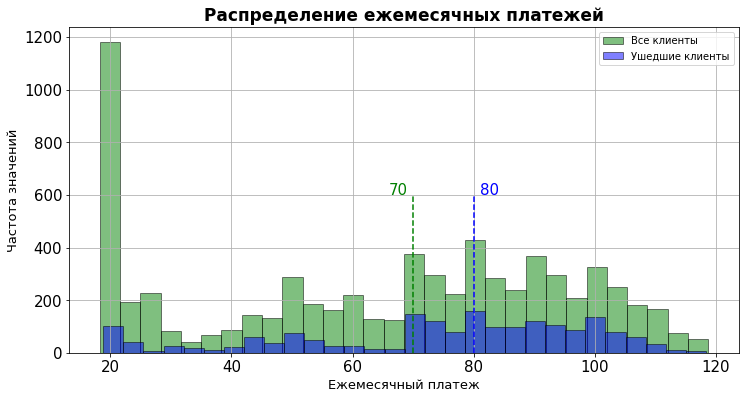

In [27]:
ax = full.plot(kind='hist', y='monthlycharges', ec='black', bins=30, 
                              linewidth=1, alpha=0.5, label='Все клиенты', color='g')
notclient.plot(kind='hist', y='monthlycharges', ec='black', bins=30,linewidth=1, alpha=0.5, 
                         label='Ушедшие клиенты', ax=ax, figsize=(12,6),grid=True, legend=True, fontsize = 15, color='b')
ax.vlines(70, 0, 600, color= 'g', linestyle ='--',)
ax.vlines(80, 0, 600, color= 'b', linestyle ='--',)
ax.text(81, 600, '80', fontsize=15, color='b')
ax.text(66, 600, '70', fontsize=15, color='g')
ax.set_ylabel('Частота значений', fontsize=13)
ax.set_xlabel('Ежемесячный платеж', fontsize=13)
ax.set_title('Распределение ежемесячных платежей', fontsize=17, fontweight='bold')
plt.show()

По графику видно, что среди ушедших клиентов больше всего тех, у кого ежемесячный платеж был в интервале от 70 до 110. Среди всех клиентов очень много тех кто платит в месяц 20. Из этого можно предположить, что большой размер ежемесячного платежа повышает вероятность что клиент уйдет.

Но на графике также видно, что клиентов с ежемесячным платежом в 20 уходило больше, чем клиентов с ежемесячным платежом, например, в 60. Т.е. есть еще факторы, влияющие на уход клиента.

In [28]:
#посмотрим на время жизни ушедших клиентов
notclient_life=notclient.pivot_table(index= 'lifetime', values = 'customerid', aggfunc= 'count')
notclient_life.columns=['count']
display(notclient_life.sort_values(by='count', ascending= False).head(10))

,count
lifetime,
31,198
30,182
61,123
153,64
92,63
122,58
214,51
365,38
91,31


Больше всего клиентов ушло через 30, 31 и 61 день после подключения, те всего через 1-2 месяца. Эти клиенты могли быть недовольны качеством услуг или соотношением цена-качество, либо у них был пробный период, после которого они нашли провайдера с более интересными для них услугами.

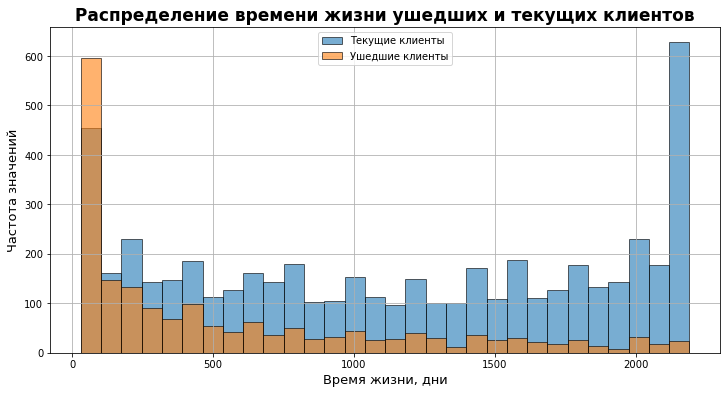

In [29]:
#рассмотрим на графике

notclient_payment=full.pivot_table(index=full.index, values = 'lifetime', columns='сlientgroup').plot.hist(
               figsize=(12,6), alpha=0.6, ec='black', grid=True, bins=30)
plt.ylabel('Частота значений', fontsize=13)
plt.xlabel('Время жизни, дни', fontsize=13)
plt.title('Распределение времени жизни ушедших и текущих клиентов', fontsize=17, fontweight='bold')
plt.legend(['Текущие клиенты', 'Ушедшие клиенты'])
plt.show()

На графике видно что большинство клиентов уходит через непродолжительное время после заключения контракта. Чем дольше длится контракт, тем выше вероятность, что клиент останется.

*Проведем анализ поведения клиентов*

**Общее количество клиентов**

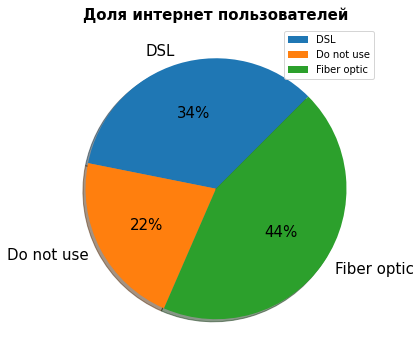

In [30]:
full.pivot_table(index='internetservice', values='customerid', 
                aggfunc = 'count').plot(kind='pie',shadow = True, subplots = True,
                fontsize=15,figsize= (6,6), startangle =45,autopct =lambda p: '{:.0f}%'.format(p))
plt.legend(loc=1)
plt.axis('off')
plt.title('Доля интернет пользователей', fontsize=15, fontweight='bold')
plt.show()

In [31]:
#объединим пользователей телефонной связи с наличием параллельных линий и без в одну группу -  User
def phone_user(multiplelines):      
    try:
        if multiplelines == 'No' or multiplelines == 'Yes':
            return 'User'
        else:
            return 'Do not use'
    except:
        print('ошибочное значение')
full['phone_user'] = full['multiplelines'].apply(phone_user) 
full['phone_user'].unique()

array(['Do not use', 'User'], dtype=object)

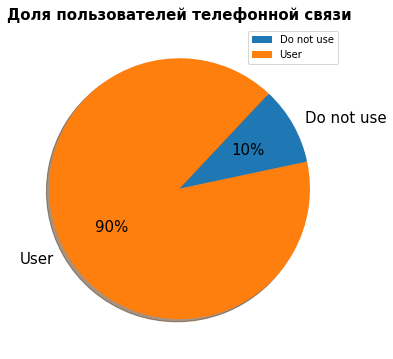

In [32]:
full.pivot_table(index='phone_user', values='customerid', 
                 aggfunc = 'count').plot(kind='pie',shadow = True, subplots = True,
                fontsize=15, figsize= (6,6), startangle =12,autopct =lambda p: '{:.0f}%'.format(p))
plt.legend(loc=1)
plt.axis('off')
plt.title('Доля пользователей телефонной связи', fontsize=15, fontweight='bold')
plt.show()

Среди всех клиентов 10% не пользуется услугами телефонной связи и 22% не пользуются интернетом. Среди пользователей интернета 34% подключаются через телефонную линию (DSL) и немного больше - 44% через оптоволоконный кабель (Fiber optic).

**Ушедшие клиенты**

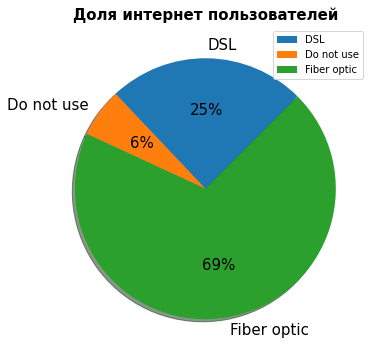

In [33]:
notclient.pivot_table(index='internetservice', values='customerid', 
                 aggfunc = 'count').plot(kind='pie',shadow = True, subplots = True,
                 fontsize=15, figsize= (6,6), startangle =45,autopct =lambda p: '{:.0f}%'.format(p))
plt.legend(loc=1)
plt.axis('off')
plt.title('Доля интернет пользователей', fontsize=15, fontweight='bold')
plt.show()

In [34]:
#объединим пользователей телефонной связи с наличием параллельных линий и без в одну группу -  User
def phone_user(multiplelines):      
    try:
        if multiplelines == 'No' or multiplelines== 'Yes':
            return 'User'
        else:
            return 'Do not use'
    except:
        print('ошибочное значение')
notclient['phone_user'] = notclient['multiplelines'].apply(phone_user) 
notclient['phone_user'].unique()

array(['User', 'Do not use'], dtype=object)

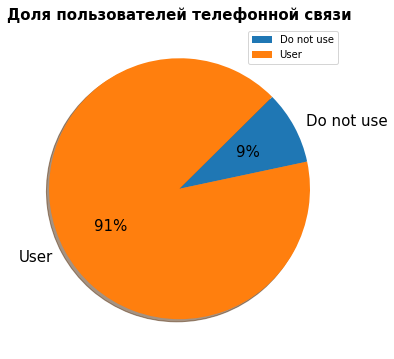

In [35]:
notclient.pivot_table(index='phone_user', values='customerid', 
                 aggfunc = 'count').plot(kind='pie',shadow = True, subplots = True,
                fontsize=15, figsize= (6,6), startangle =12,autopct =lambda p: '{:.0f}%'.format(p))
plt.legend(loc=1)
plt.axis('off')
plt.title('Доля пользователей телефонной связи', fontsize=15, fontweight='bold')
plt.show()

Среди ушедших клиентов только 9% не пользовались телефонной связью и 6% не пользовались интернетом. Больше всего из пользователей интернета ушло тех, кто подключался через оптоволоконный кабель (Fiber optic). Можно предположить что ушедшие клиенты были недовольны качеством интернет соединения.

### Вывод

26.5% процентов клиентов разорвали контракт с компанией. У ушедших клиентов средний месячный платеж выше, чем в целом у всех клиентов. Больше всего уходит клиентов через 1-2 месяца после заключения контракта.<div> Можно предположить, что клиенты уходят из-за того что недовольны соотношением цена-качество услуг. Среди ушедших много тех, кто подключался к интернету через оптоволоконный кабель (Fiber optic).
    
То есть в первую очередь стоит обратить внимание на только подключившихся клиентов с ежемесячным платежом выше, чем в среднем по всем клиентам - 65.

## 4. Подготовка данных для обучения

Для корректной работы модели нам не понадобятся все колонки, так как это может затормозить работу. 

Проверим корреляцию количественных признаков

In [36]:
display(full.corr())

,seniorcitizen,monthlycharges,totalcharges,сlientgroup,lifetime
seniorcitizen,1.000000,0.219874,0.102411,0.150541,0.015630
monthlycharges,0.219874,1.000000,0.651065,0.192858,0.246715
totalcharges,0.102411,0.651065,1.000000,-0.199484,0.825811
сlientgroup,0.150541,0.192858,-0.199484,1.000000,-0.354496
lifetime,0.015630,0.246715,0.825811,-0.354496,1.000000


Корреляция между totalcharges и lifetime больше чем 0.8. Удалим totalcharges, тк есть monthlycharges

In [37]:
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 23 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7032 non-null   object        
 1   gender            7032 non-null   object        
 2   seniorcitizen     7032 non-null   int64         
 3   partner           7032 non-null   object        
 4   dependents        7032 non-null   object        
 5   begindate         7032 non-null   datetime64[ns]
 6   enddate           7032 non-null   object        
 7   type              7032 non-null   object        
 8   paperlessbilling  7032 non-null   object        
 9   paymentmethod     7032 non-null   object        
 10  monthlycharges    7032 non-null   float64       
 11  totalcharges      7032 non-null   float64       
 12  сlientgroup       7032 non-null   int64         
 13  lifetime          7032 non-null   int64         
 14  multiplelines     7032 n

Колонка customerid не несет в себе никакой полезной информации, phone_user создавалась только для анализа поведения пользователей, а begindate и enddate могут привести к утечке данных - вместо них оставим только колонку время жизни клиента lifetime

Все категориальные признаки имеют тип данных object, кроме данных в колонке seniorcitizen. Преобразуем их в object.
Колонка clientgroup будет целевым признаком. Остальные колонки: monthlycharges, lifetime - количественные признаки

In [38]:
full=full.drop(['customerid','begindate','enddate', 'phone_user', 'totalcharges'], axis =1)
full['seniorcitizen']=full['seniorcitizen'].replace( 0 , 'No')
full['seniorcitizen']=full['seniorcitizen'].replace( 1 , 'Yes')

In [39]:
full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   seniorcitizen     7032 non-null   object 
 2   partner           7032 non-null   object 
 3   dependents        7032 non-null   object 
 4   type              7032 non-null   object 
 5   paperlessbilling  7032 non-null   object 
 6   paymentmethod     7032 non-null   object 
 7   monthlycharges    7032 non-null   float64
 8   сlientgroup       7032 non-null   int64  
 9   lifetime          7032 non-null   int64  
 10  multiplelines     7032 non-null   object 
 11  internetservice   7032 non-null   object 
 12  onlinesecurity    7032 non-null   object 
 13  onlinebackup      7032 non-null   object 
 14  deviceprotection  7032 non-null   object 
 15  techsupport       7032 non-null   object 
 16  streamingtv       7032 non-null   object 


Разобъем данные на признаки и целевой признак и разделим их на 2 выборки: обучающую и тестовую.

In [40]:
target = full['сlientgroup'] #целевой признаком
features = full.drop(['сlientgroup'], axis=1) 
features_train, features_test, target_train, target_test = train_test_split(
        features,target,stratify=target, test_size=0.3, random_state=12345)
print('Обучающая выборка: ', features_train.shape,  target_train.shape)
print('Тестовая выборка: ', features_test.shape,  target_test.shape)

Обучающая выборка:  (4922, 17) (4922,)
Тестовая выборка:  (2110, 17) (2110,)


Проведем кодирование категориальных признаков

In [41]:
features_train_ohe=pd.get_dummies(features_train, drop_first=True)
features_test_ohe=pd.get_dummies(features_test, drop_first=True)

In [42]:
display(features_test_ohe.head())
features_test_ohe.shape

,monthlycharges,lifetime,gender_Male,seniorcitizen_Yes,partner_Yes,dependents_Yes,type_One year,type_Two year,paperlessbilling_Yes,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check,multiplelines_No,multiplelines_Yes,internetservice_Do not use,internetservice_Fiber optic,onlinesecurity_No,onlinesecurity_Yes,onlinebackup_No,onlinebackup_Yes,deviceprotection_No,deviceprotection_Yes,techsupport_No,techsupport_Yes,streamingtv_No,streamingtv_Yes,streamingmovies_No,streamingmovies_Yes
309,78.75,1461,1,0,0,1,1,0,1,1,0,0,0,1,0,0,0,1,1,0,0,1,1,0,0,1,0,1
5313,81.90,792,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1
1712,19.70,2191,1,0,1,0,0,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3629,24.55,2191,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3149,72.75,123,0,1,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,1,1,0,1,0,1,0,1,0


(2110, 28)

Проведем масштабирование количественных признаков

In [43]:
numeric=['monthlycharges', 'lifetime']
scaler=StandardScaler()
scaler.fit((features_train_ohe[numeric]))
features_train_ohe[numeric]=scaler.transform(features_train_ohe[numeric])
features_test_ohe[numeric]=scaler.transform(features_test_ohe[numeric])
display(features_train_ohe.shape)
display(features_train_ohe.head())

(4922, 28)

,monthlycharges,lifetime,gender_Male,seniorcitizen_Yes,partner_Yes,dependents_Yes,type_One year,type_Two year,paperlessbilling_Yes,paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check,multiplelines_No,multiplelines_Yes,internetservice_Do not use,internetservice_Fiber optic,onlinesecurity_No,onlinesecurity_Yes,onlinebackup_No,onlinebackup_Yes,deviceprotection_No,deviceprotection_Yes,techsupport_No,techsupport_Yes,streamingtv_No,streamingtv_Yes,streamingmovies_No,streamingmovies_Yes
6325,1.298360,1.413795,0,0,0,1,0,1,1,0,1,0,0,1,0,1,1,0,0,1,1,0,0,1,0,1,0,1
2432,-0.115736,-1.040535,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,1,1,0,1,0,1,0
6352,-0.069263,-1.040535,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,1,1,0,0,1
3813,-1.133154,0.553570,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,1,0,1,0
3122,-1.138134,-0.142675,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,1,0,1,0,1,0,1,0


Проверим баланс классов в целевом признаке

0    0.734215
1    0.265785
Name: сlientgroup, dtype: float64


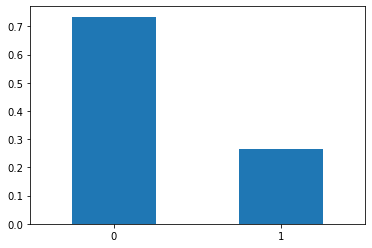

In [44]:
class_frequency=target.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')
plt.xticks(rotation=0)
plt.show()

Дисбаланс классов примерно 1:3

## 5. Обучение простых моделей

Рассмотрим несколько простых моделей: Логистическая регрессия, Дерево решений и Случайный лес

In [45]:
#функция для кроссвалидации по модели

def calc(model, features, target, params):
    roc_auc_scorer=make_scorer(roc_auc_score, greater_is_better=True, needs_threshold=True)
    grid= GridSearchCV(model, params, scoring=roc_auc_scorer, cv=5, n_jobs = -1)
    grid.fit(features, target)
    print('Лучшие гиперпараметры для модели: ', grid.best_params_)
    print('Лучшая метрика ROC_AUC: {:.3f}'.format(grid.best_score_))

Сначала попробуем кроссвалидацию со встроеной борьбой с дисбалансом по гипперпараметру class_weight

**Логистическая регрессия**

In [46]:
%%time
regress=LogisticRegression(random_state=12345)
regress_params={'class_weight':['balanced',None], 'C':[2, 5,8]}
calc(regress, features_train_ohe, target_train, regress_params )

/Users/katerinakasanova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/katerinakasanova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

Лучшие гиперпараметры для модели:  {'C': 2, 'class_weight': None}
Лучшая метрика ROC_AUC: 0.841
CPU times: user 268 ms, sys: 106 ms, total: 374 ms
Wall time: 4.86 s


/Users/katerinakasanova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/katerinakasanova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

Кроссвалидация показала, что лучшая метрика ROC_AUC = 0.841 достигается, если class_weight не применять.

**Дерево решений**

In [47]:
%%time
tree= DecisionTreeClassifier(random_state=12345)
tree_params = {'max_depth': range(1, 17, 5),'class_weight':['balanced',None]}
calc(tree, features_train_ohe, target_train, tree_params )

Лучшие гиперпараметры для модели:  {'class_weight': 'balanced', 'max_depth': 6}
Лучшая метрика ROC_AUC: 0.843
CPU times: user 91.3 ms, sys: 14.4 ms, total: 106 ms
Wall time: 496 ms


Кровссвалидация показала, что лучшая метрика ROC_AUC = 0.843 достигается так же без баланса

**Случайный лес**

In [48]:
%%time
forest = RandomForestClassifier(random_state=12345)
forest_params={'max_depth': range(1, 13, 2), 'class_weight':['balanced',None], 'n_estimators':range(1,45,5)}
calc(forest, features_train_ohe, target_train,forest_params)

Лучшие гиперпараметры для модели:  {'class_weight': None, 'max_depth': 7, 'n_estimators': 31}
Лучшая метрика ROC_AUC: 0.852
CPU times: user 1.25 s, sys: 135 ms, total: 1.39 s
Wall time: 22.5 s


Лучшая метрика ROC_AUC=0.852 достигается без баланса классов, она немного лучше чем у Логистической регрессии и Дерева решений. 

Попробуем изменить баланс классов вручную.

In [49]:
#Функция для увеличения положительных объектов в выборке на n-количество раз(repeat)

def upsample(features, target, repeat):
    features_zeros=features[target==0]
    features_ones=features[target==1]
    target_zeros=target[target==0]
    target_ones=target[target==1]
    features_upsampled=pd.concat([features_zeros]+[features_ones]*repeat)
    target_upsampled=pd.concat([target_zeros]+[target_ones]*repeat)
    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled,random_state=12345)
    return features_upsampled, target_upsampled

In [50]:
#увеличим количество положительных объектов в 3 раза

features_upsampled, target_upsampled = upsample(features_train_ohe, target_train, 3)
print(features_upsampled.shape)
print(target_upsampled.shape)

(7538, 28)
(7538,)


1    0.520562
0    0.479438
Name: сlientgroup, dtype: float64


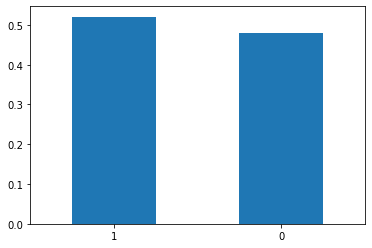

In [51]:
class_frequency=target_upsampled.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')
plt.xticks(rotation=0)
plt.show()

**Логистическая регрессия**

In [52]:
%%time
regress=LogisticRegression(random_state=12345)
regress_params={ 'C':[5, 10,15]}
calc(regress, features_upsampled, target_upsampled, regress_params)

Лучшие гиперпараметры для модели:  {'C': 5}
Лучшая метрика ROC_AUC: 0.842
CPU times: user 232 ms, sys: 17.4 ms, total: 250 ms
Wall time: 855 ms


/Users/katerinakasanova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Метрика практически не изменилась

**Дерево решений**

In [53]:
%%time
tree= DecisionTreeClassifier(random_state=12345)
tree_params = {'max_depth': range(1, 10, 3)}
calc(tree, features_upsampled, target_upsampled, tree_params)

Лучшие гиперпараметры для модели:  {'max_depth': 7}
Лучшая метрика ROC_AUC: 0.870
CPU times: user 78.2 ms, sys: 15.5 ms, total: 93.8 ms
Wall time: 220 ms


ROC_AUC - 0.870, это значительно больше, чем без учета дисбаланса

**Случайный лес**

In [54]:
%%time
forest = RandomForestClassifier(random_state=12345)
forest_params={'max_depth': range(1, 10, 2), 'n_estimators':range(1,21,5)}
calc(forest, features_upsampled, target_upsampled,forest_params)

Лучшие гиперпараметры для модели:  {'max_depth': 9, 'n_estimators': 16}
Лучшая метрика ROC_AUC: 0.903
CPU times: user 307 ms, sys: 33.8 ms, total: 341 ms
Wall time: 3.03 s


ROC_AUC - 0.903, так же значительно больше стал, чем без учета дисбаланса

Попоробуем уменьшить кол-во отрицательных объектов в выборке

In [55]:
#Функция для уменьшения отрицательных  объектов в выборке на n-долю (fraction)
def downsample(features, target, fraction):
    features_zeros=features[target==0]
    features_ones=features[target==1]
    target_zeros=target[target==0]
    target_ones=target[target==1]
    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)]+[features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)]+[target_ones])
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled,random_state=12345)
    return features_downsampled, target_downsampled

In [56]:
features_downsampled, target_downsampled = downsample(features_train_ohe, target_train, 0.35)

1    0.508356
0    0.491644
Name: сlientgroup, dtype: float64


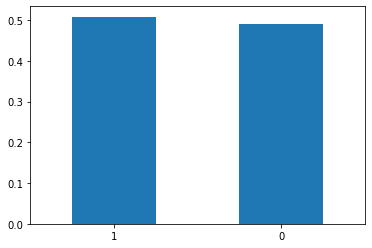

In [57]:
class_frequency=target_downsampled.value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')
plt.xticks(rotation=0)
plt.show()

**Логистическая регрессия**

In [58]:
%%time
regress=LogisticRegression(random_state=12345)
regress_params={ 'C':[3, 5, 10]}
calc(regress, features_downsampled, target_downsampled, regress_params)

Лучшие гиперпараметры для модели:  {'C': 10}
Лучшая метрика ROC_AUC: 0.837
CPU times: user 143 ms, sys: 10 ms, total: 153 ms
Wall time: 468 ms


/Users/katerinakasanova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/katerinakasanova/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/l

**Дерево решений**

In [59]:
%%time
tree= DecisionTreeClassifier(random_state=12345)
tree_params = {'max_depth': range(1, 17, 5)}
calc(tree, features_downsampled, target_downsampled, tree_params)

Лучшие гиперпараметры для модели:  {'max_depth': 6}
Лучшая метрика ROC_AUC: 0.831
CPU times: user 63.3 ms, sys: 8.79 ms, total: 72 ms
Wall time: 206 ms


**Случайный лес**

In [60]:
%%time
forest = RandomForestClassifier(random_state=12345)
forest_params={'max_depth': range(1, 13, 2), 'n_estimators':range(1,45,5)}
calc(forest,  features_downsampled, target_downsampled,forest_params)

Лучшие гиперпараметры для модели:  {'max_depth': 7, 'n_estimators': 36}
Лучшая метрика ROC_AUC: 0.846
CPU times: user 462 ms, sys: 31.5 ms, total: 493 ms
Wall time: 8.37 s


Во всех трех вариантрах метрика даже хуже, чем без учета баланса

Выведем результаты в таблицу

In [61]:
line = {'Модель':['Линейная регрессия' ,'Решающее дерево',  'Случайный лес'], 
        'ROC-AUC без учета баланса': [0.842, 0.843,  0.853],
        'ROC-AUC upsample x3': [0.842, 0.870,  0.903],
       'ROC-AUC downsample x0.35': [0.837,0.831, 0.846]}
pivot = pd.DataFrame.from_dict(line)

display(pivot)

,Модель,ROC-AUC без учета баланса,ROC-AUC upsample x3,ROC-AUC downsample x0.35
0,Линейная регрессия,0.842,0.842,0.837
1,Решающее дерево,0.843,0.870,0.831
2,Случайный лес,0.853,0.903,0.846


Во всех трех случаях лучшая метрика ROC_AUC у Случайного леса: с upsample x3 она улучшается, с downsample x0.35 становится еще хуже, чем без учета баланса классов. 

Самая лучшая метрика Случайный лес ROC-AUC upsample x3 = 0.903

## 6. Тестирование лучшей модели

Точность:0.531
Полнота:0.784
Accuracy:0.758
ROC_AUC:0.854


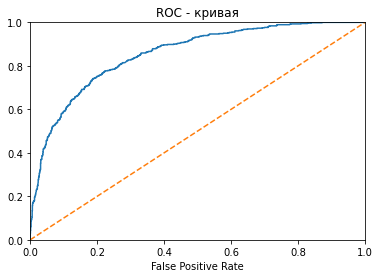

In [62]:
features_upsampled, target_upsampled = upsample(features_train_ohe, target_train, 3)
forest = RandomForestClassifier(random_state=12345, n_estimators=16, max_depth=9)
forest.fit(features_upsampled, target_upsampled)
predictions_test=forest.predict(features_test_ohe) 
probabilities_test = forest.predict_proba(features_test_ohe)
probabilities_one_test = probabilities_test[:,1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
plt.figure()  
plt.plot(fpr, tpr) #ROC-кривая модели 
plt.plot([0,1],[0,1], linestyle='--')  #ROC-кривая случайной модели 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.title('ROC - кривая')
print('Точность:{:.3f}' .format(precision_score(target_test, predictions_test)))
print('Полнота:{:.3f}' .format(recall_score(target_test, predictions_test)))
print('Accuracy:{:.3f}' .format(accuracy_score(target_test, predictions_test)))
print('ROC_AUC:{:.3f}' .format(roc_auc_score(target_test, probabilities_one_test)))

На тестовой выборке модель показала ROC_AUC = 0.854 и Accuracy = 0.758. Не очень высокие показатели. К тому же точность всего 0.531 и на обучающей выборке был ROC_AUC = 0.903, что говорит о небольшом переобучении и со временем модель модель может потерять в качестве.

## 7. Обучение и тестирование модели градиентного бустинга

Попробуем модель градиентного бустинга CatBoost, так как обучение на предыдущем этапе не дало удовлетворительных результатов. 

In [63]:
#создадим список категориальных признаков
cat_features =['gender', 'seniorcitizen', 'partner','dependents','type','paperlessbilling',
               'paymentmethod','multiplelines','internetservice','onlinesecurity','onlinebackup',
               'deviceprotection','techsupport','streamingtv','streamingmovies']

In [64]:
%%time
cat = CatBoostClassifier(iterations=200, verbose=False,cat_features = cat_features)
cat_params = {'learning_rate':[0.5, 0.8, 1.0], 'depth':[5,10, 15]} 
cat_grid = GridSearchCV(cat, cat_params, scoring='roc_auc',  cv=4, n_jobs = -1)
cat_grid.fit(features_train, target_train)

print('Лучшая метрика ROC_AUC: {:.3f}' .format(cat_grid.best_score_))
print('Лучшие гиперпараметры для модели: ', cat_grid.best_params_)

Лучшая метрика ROC_AUC: 0.906
Лучшие гиперпараметры для модели:  {'depth': 5, 'learning_rate': 0.5}
CPU times: user 4.7 s, sys: 626 ms, total: 5.33 s
Wall time: 1h 16min 31s


ROC_AUC на кроссвалидации 0.906 - намного лучше чем у простых моделей

И сразу проведем тестирование модели: 

Точность: 0.800
Полнота: 0.720
Accuracy: 0.878
ROC_AUC: 0.916
CPU times: user 4.34 s, sys: 287 ms, total: 4.62 s
Wall time: 2.02 s


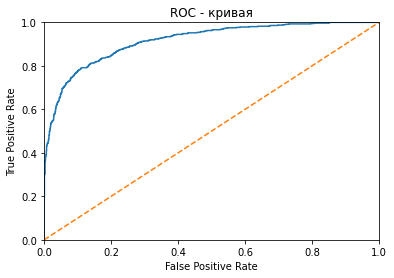

In [66]:
%%time
cat_test = CatBoostClassifier(iterations= 200, verbose=0,cat_features=cat_features, 
                        learning_rate=0.5,depth=5, random_state=12345)
cat_test.fit(features_train, target_train)
predictions_cat=cat_test.predict(features_test)
probabilities_test =cat_test.predict_proba(features_test)
probabilities_one_test = probabilities_test[:,1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
plt.figure()  
plt.plot(fpr, tpr) #ROC-кривая модели 
plt.plot([0,1],[0,1], linestyle='--')  #ROC-кривая случайной модели 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - кривая')
print('Точность: {:.3f}' .format(precision_score(target_test, predictions_cat)))
print('Полнота: {:.3f}' .format(recall_score(target_test, predictions_cat)))
print('Accuracy: {:.3f}' .format(accuracy_score(target_test, predictions_cat)))
print('ROC_AUC: {:.3f}' .format(roc_auc_score(target_test, probabilities_one_test)))

На тесте ROC_AUC = 0.916 и Accuracy = 0.878

Проверим важность признаков для этой модели:

In [67]:
importance = cat_test.feature_importances_
feature_list=list(features_train.columns)
feature_results=pd.DataFrame({'feature': feature_list, 'importance': importance}).sort_values('importance', ascending=False).reset_index(drop=True)
display(feature_results)

,feature,importance
0,lifetime,57.214145
1,monthlycharges,11.685069
2,type,4.932529
3,techsupport,4.509663
4,paymentmethod,3.466323
5,multiplelines,2.722612
6,onlinebackup,2.354551
7,internetservice,2.102662
8,onlinesecurity,1.906594
9,paperlessbilling,1.900346


In [69]:
#Протестируем модель без признаков низкой важности

cat_features_filterred = ['type',
               'paymentmethod','multiplelines','onlinebackup','internetservice',
               'techsupport','onlinesecurity']
features_train_filtered = features_train.drop(['dependents','partner','deviceprotection','streamingmovies',
                    'seniorcitizen','streamingtv','gender','paperlessbilling'],axis =1 )
features_test_filtered = features_test.drop(['dependents','partner','deviceprotection','streamingmovies',
                    'seniorcitizen','streamingtv','gender','paperlessbilling'], axis =1)



Точность: 0.802
Полнота: 0.724
Accuracy: 0.879
ROC_AUC: 0.924
CPU times: user 3.31 s, sys: 319 ms, total: 3.63 s
Wall time: 1.68 s


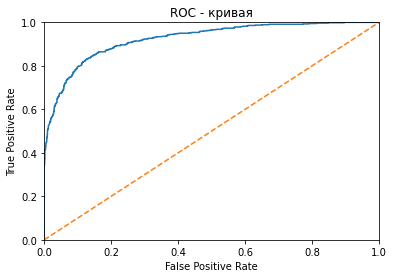

In [70]:
%%time
cat_test = CatBoostClassifier(iterations= 200, verbose=0,cat_features=cat_features_filterred, 
                        learning_rate=0.5,depth=5, random_state=12345)
cat_test.fit(features_train_filtered, target_train)
predictions_cat=cat_test.predict(features_test_filtered)
probabilities_test =cat_test.predict_proba(features_test_filtered)
probabilities_one_test = probabilities_test[:,1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
plt.figure()  
plt.plot(fpr, tpr) #ROC-кривая модели 
plt.plot([0,1],[0,1], linestyle='--')  #ROC-кривая случайной модели 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - кривая')
print('Точность: {:.3f}' .format(precision_score(target_test, predictions_cat)))
print('Полнота: {:.3f}' .format(recall_score(target_test, predictions_cat)))
print('Accuracy: {:.3f}' .format(accuracy_score(target_test, predictions_cat)))
print('ROC_AUC: {:.3f}' .format(roc_auc_score(target_test, probabilities_one_test)))

ROC_AUC немного повысился и равен 0.924, Accuracy = 0.879. Так же немного увеличились Точность и Полнота.

Проверим модель на адекватность.

Сначала проверим, что модель не предсказывает только какой-то один класс.

In [71]:
collections.Counter(predictions_cat)

Counter({0: 1604, 1: 506})

Предсказывает оба класса

In [73]:
#Теперь сравним модель с константной моделью, 
#которая любому объекту пронозирует класс "0" (тк этого класса большинство)

predictions_train = pd.Series(target_train.replace(1, 0))
print('Accuracy',accuracy_score(target_train, predictions_train))
print('ROC_AUC:', roc_auc_score(target_train, predictions_train))

Accuracy 0.7342543681430312
ROC_AUC: 0.5


У модели метрики Accuracy и ROC_AUC выше чем у константной модели

**Вывод**
Модели удалось превысить порог 0.88, модель обучена и адекватна

## 8. Общие выводы

Оператор связи «Ниединогоразрыва.ком» предоставил данные в 4 файлах. Необходимо было обучить модель, которая предсказывала бы отток клиентов. Целевая метрика - ROC_AUC не ниже 0.88

После предобаработки данных объединили их в один файл.

Данные разделили на обучающую и тестовую выборки в пропорции 70:30.

Произвели предобработку признаков: категориальные данные закодировали, количественные отмасштабировали. Для обучения взяли 3 простые модели - Логистическая регрессия, Дерево решений, Случайный лес - и модель градиентного бустинга - CatBoost и с помощью кроссвалидации нашли оптимальные параметры.

Среди простых моделей лучшей на кроссвалидации оказалась модель Случайный лес. Но на тесте метрика ROC_AUC не смогла достичь порога 0.88 и accuracy лишь ненамного лучше, чем у константной модели. Модель же градиентного бустинга показала гораздо лучший результат: на тесте метрика ROC_AUC = 0.924 и accuracy=0.879, что лучше чем у константной модели и выше целевого порога 0.88.

Следовательно модель CatBoost можно брать в работу.

# Отчет о проделаной работе

*- Какие пункты плана были выполнены, а какие — нет (поясните почему)?*

Все пункты плана были выполнены, так же был добавлен еще один пункт с обучением и тестированием более сложной модели, так как выбранные простые модели не давали нужный результат, который был задан для себя (не преодолевали порог в 0.88). Для этого была рассмотрена модель градиентного бустинга, так как по опыту, вероятность получения выоского значения roc_auc гораздо выше, чем у простых моделей.


*- Какие трудности возникли и как вы их преодолели?*

Особо вопросов в ходе работы не возникало, помогало пользование предыдущими проектами, следование комментариям прошлых ревьюеров и записи вебинаров с преподавателем.

*- Какие ключевые шаги в решении задачи выделили?*

Я считаю, что ключевым является грамотная предобработка данных, ей все таки стоит уделять особое внимание, так как в ходе анализа мы понимаем на что следует обратить особое внимание, а что можно отбросить в сторону и не использовать в дальнейшнем исследовании, чтобы не создавало проблем с обучением моделей.

Так же правильное чтение и понимание изначально выгруженных данных. Конечно же, если не понятно, то, считаю, что лучше уточнить и спросить у коллеги, который занимается непосредственно работой с архивированием данных.

*- Какая ваша итоговая модель и какое у неё качество?*

Итоговая модель - CatBoost с показателями roc_auc = 0.924 и accuracy=0.879. 
Это самые высокие показатели среди четырех тестируемых моделей.